In [ ]:
# Imports
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from time import time

from skimage.io import imread
from skimage.color import rgb2gray
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torchvision.datasets as datasets
import skimage.io as io
from skimage.transform import resize
import natsort
from natsort import natsorted
from numpy import asarray
from tqdm.notebook import tqdm


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive/')
!ls '/content/drive/'

Mounted at /content/drive/
MyDrive


In [ ]:
def get_data(path, start, end, size=(128,128)):
  """
  function to load image data of cells and normalize the pictures for dataloader.
  """
  images = []
  annotations = []
  image_names = []
  mask_names = []
  # First get names of all images to read organized
  image_names = [ f.name for f in os.scandir(path+'/image')][start:end]
  image_names = natsorted(image_names) # Sort so that we get correct number matching between images and annotations
  mask_names = [ f.name for f in os.scandir(path+'/mask')][start:end]
  mask_names = natsorted(mask_names)
  # print('sorted_names', image_names)
  # print(mask_names)

  # Load images
  for image_name in image_names:
    im = io.imread(os.path.join(path+'/image', image_name))
    # im = rgb2gray(im)
    im = np.array(im, np.float32)
    # im = np.moveaxis(im, 2, -3)
    im = resize(im, size, anti_aliasing=True)
    pixels = asarray(im)
    pixels = pixels.astype('float32')
    mean, std = pixels.mean(), pixels.std()
    # print('Before normalization', 'Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    # global standardization of pixels
    pixels = (pixels - mean) / std
    mean2, std2 = pixels.mean(), pixels.std()
    # assert [np.isclose([mean2, std2], [0, 1.0], atol=0.0001)] == [ True, True]
    pixels = np.moveaxis(pixels, 2, -3) # move channels to last i.e: [C,W,H]
    # print('images', pixels.shape)
    images.append(pixels)

  # Load masks
  for image_name in mask_names:
    an = io.imread(os.path.join(path+'/mask', image_name))
    # an = rgb2gray(an)
    an = np.array(an, np.float32)
    # an = np.moveaxis(an, 2, -3)
    an = resize(an, size, anti_aliasing=True)
    pixels = asarray(an)
    pixels = pixels.astype('float32')
    mean, std = pixels.mean(), pixels.std()
    # print('Before normalization', 'Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    # global standardization of pixels
    pixels = (pixels - mean) / std
    mean2, std2 = pixels.mean(), pixels.std()
    # assert [np.isclose([mean2, std2], [0, 1.0], atol=0.0001)] == [ True, True]
    # assert [img.shape==pixels.shape] == [True]
    # print('annotations', pixels.shape)
    annotations.append(pixels)

  X = images
  Y = annotations
  del images
  del annotations
  print(image_names)
  # print(anno_names[0:10])
  # print(im_names[0:10])
  return (X, Y)

In [ ]:
trainpath = '/content/drive/MyDrive/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train' # there are a total of 330 images in the train file

X, Y = get_data(path=trainpath, start=0, end=80, size=(128,128))

['train_1.bmp', 'train_2.bmp', 'train_3.bmp', 'train_4.bmp', 'train_6.bmp', 'train_7.bmp', 'train_8.bmp', 'train_9.bmp', 'train_10.bmp', 'train_12.bmp', 'train_13.bmp', 'train_14.bmp', 'train_15.bmp', 'train_17.bmp', 'train_18.bmp', 'train_19.bmp', 'train_20.bmp', 'train_21.bmp', 'train_22.bmp', 'train_23.bmp', 'train_24.bmp', 'train_25.bmp', 'train_26.bmp', 'train_27.bmp', 'train_28.bmp', 'train_29.bmp', 'train_30.bmp', 'train_31.bmp', 'train_32.bmp', 'train_33.bmp', 'train_34.bmp', 'train_35.bmp', 'train_36.bmp', 'train_38.bmp', 'train_39.bmp', 'train_40.bmp', 'train_41.bmp', 'train_42.bmp', 'train_43.bmp', 'train_44.bmp', 'train_45.bmp', 'train_46.bmp', 'train_47.bmp', 'train_48.bmp', 'train_49.bmp', 'train_50.bmp', 'train_51.bmp', 'train_52.bmp', 'train_53.bmp', 'train_54.bmp', 'train_55.bmp', 'train_56.bmp', 'train_58.bmp', 'train_59.bmp', 'train_60.bmp', 'train_61.bmp', 'train_62.bmp', 'train_63.bmp', 'train_64.bmp', 'train_65.bmp', 'train_66.bmp', 'train_67.bmp', 'train_68.bmp',

In [ ]:
# Check to make sure shapes are correct.

nr = 1
X_ex = np.moveaxis(X[nr], 0, -1)
Y_ex = Y[nr]
print(X_ex.shape)
print(Y_ex.shape)

(128, 128, 3)
(128, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


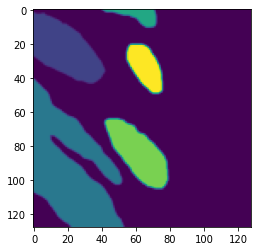

In [ ]:
# Veiw some images
plt.imshow(X_ex)
plt.imshow(Y[nr])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


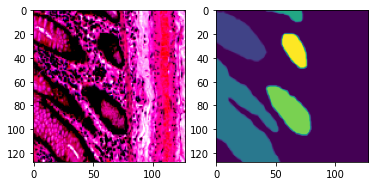

In [ ]:
plt.subplot(1, 2, 1), plt.imshow(X_ex)
plt.subplot(1, 2, 2), plt.imshow(Y[nr])
# image_mask = np.concatenate((X_ex, Y[nr]), axis=1)
plt.show()

In [ ]:
#@title
# mask = io.imread('/content/sample_data/testA_9_anno.bmp')
# mask = np.array(mask)
# obj_ids = np.unique(mask)
# # first id is the background, so remove it
# obj_ids = obj_ids[1:]

# # split the color-encoded mask into a set
# # of binary masks
# masks = mask == obj_ids[:, None, None]

# # get bounding box coordinates for each mask
# num_objs = len(obj_ids)
# boxes = []
# for i in range(num_objs):
#     pos = np.where(masks[i])
#     xmin = np.min(pos[1])
#     xmax = np.max(pos[1])
#     ymin = np.min(pos[0])
#     ymax = np.max(pos[0])
#     boxes.append([xmin, ymin, xmax, ymax])

# len(boxes)

14

In [ ]:
#@title
# import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(mask)

# for i in boxes:
#     # take regions with large enough areas
#     # if region.area >= 10:
#     # draw rectangle around segmented coins
#     xmin, ymin, xmax, ymax = i
#     rect = mpatches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
#                               fill=False, edgecolor='red', linewidth=2)
#     ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F

# from .unet_parts import *


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
# a = torch.arange(0, 4).unsqueeze(0).unsqueeze(2).expand(2, -1, 4, 3)
# b = torch.arange(3, 6).unsqueeze(0).unsqueeze(2).expand(2, -1, 4)
# a = torch.empty(10, 1, 5, 5)
# b = torch.ones(10, 5, 5)
# print(a.shape, b.shape)
# b = b.unsqueeze(1)
# # b = torch.cat([a, b], dim=1)
# print(b[1])
# b[1] = a[1]
# print('a[1]:', a[1])
# print(b[1])
# print('new size b:', b.shape)

In [ ]:
def train(model, opt, loss_fn, epochs, data_loader, print_status):

    loss_ls = []
    epoch_ls = []
    for epoch in range(epochs):
        avg_loss = 0
        model.train()

        b=0
        for X_batch, Y_batch in data_loader:


            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # print(input_size)
            # forward pass
            Y_pred = model(X_batch)

            """
            if (epoch % 10 ==0):
              plt.figure(figsize=(5,5))
              plt.imshow(Y_pred[-1,0,:,:].detach().numpy( ))
            """
            # print('Y_pred shape', Y_pred.shape)
            # print('Y_batch shape before', Y_batch.shape)
            Y_batch = Y_batch.unsqueeze(1)
            Y_batch[1] = Y_pred[1]
            loss = loss_fn(Y_pred, Y_batch)  # compute loss
            loss.backward()  # backward-pass to compute gradients
            opt.step()  # update weights

            # Compute average epoch loss
            avg_loss += loss / len(data_loader)
            #print(b)
            b=b+1
            # print(loss)

        """
        if print_status:
            print(f"Loss in epoch {epoch} was {avg_loss}")
        """
        loss_ls.append(avg_loss)
        epoch_ls.append(epoch)
        # Delete unnecessary tensors
        Y_batch[5:] = 0
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_batch.to(device))).detach().cpu()
        # del X_batch
        Y_hat[5:, 0] = 0
        clear_output(wait=True)

        # plt.subplots_adjust(bottom=1, top=2, hspace=0.2)
        for k in range(4):
            plt.subplot(3, 4, k+1)
            Y_batch2 = Variable(Y_batch[k,0,:,:], requires_grad=False)
            plt.imshow(Y_batch2.cpu().numpy(), cmap='Greys')
            # plt.imshow(X_batch[k,0,:,:].cpu().numpy( ))
            # plt.imshow(Y_batch[k].cpu().numpy( ))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='Greys')
            # plt.imshow(Y_hat[k, 0])
            plt.title('Output')
            plt.axis('off')



        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        plt.plot(epoch_ls, loss_ls, label='traning loss')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Loss')
        plt.show()

    return model

In [ ]:
def focal_loss(y_pred, y_real, gamma=2):
    y_pred = torch.clamp(F.sigmoid(y_pred), 1e-8, 1-1e-8)
    # gamma = 2
    return -torch.mean(((1-y_pred)**gamma)*y_real*torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred))

In [ ]:
batch_size = 4
dataloader2 = DataLoader(list(zip(X, Y)), batch_size=batch_size, shuffle=True)

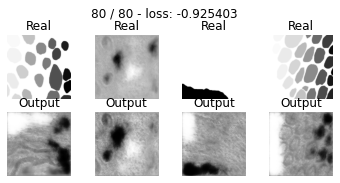

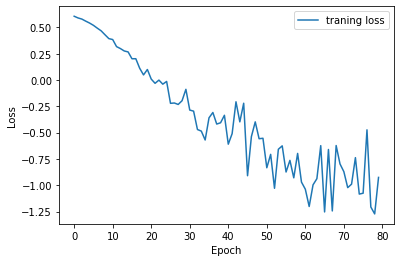

In [ ]:
# Predefine input size
# x, y = next(iter(dataloader2))
# input_size = x.shape[1]
# del x, y
# print(input_size)
n_channels = 3
n_classes = 2
# Next creat an instance of the UNet model
modelUnet = UNet().to(device)

criterion = torch.nn.BCEWithLogitsLoss()

# Now define the optimizer
optimizerUnet = optim.Adam(modelUnet.parameters(), lr = 0.000001, weight_decay=1e-2)

# And finally lets train the model
# model_out = train(modelUnet, optimizerUnet, focal_loss, 100, dataloader2, print_status=True)
model_out = train(modelUnet, optimizerUnet, criterion, 80, dataloader2, print_status=True)

In [ ]:
X_batch, Y_batch = next(iter(dataloader2))
# X = X[0].to(device)
# X = Variable(torch.from_numpy(X[0]))
model_out.eval()  # testing mode
Y_hat = F.sigmoid(model_out(X_batch.to(device))).detach().cpu()
# Y_batch[5:] = 0
# Y_hat[5:] = 0

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


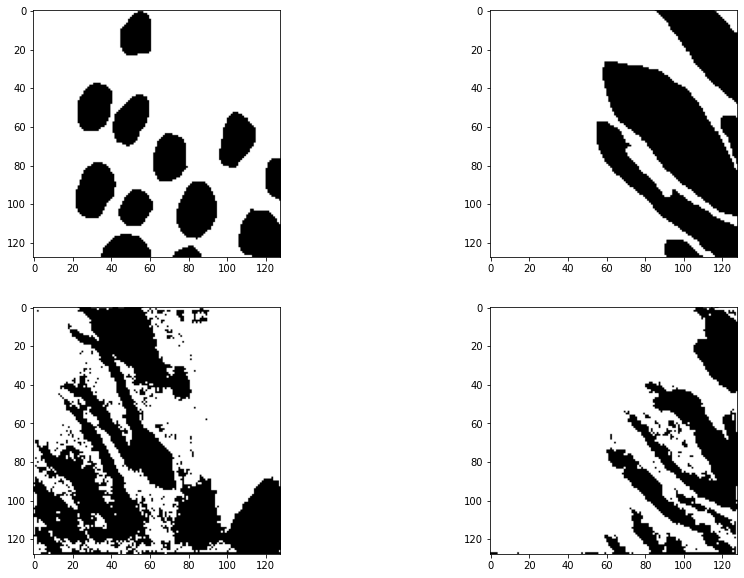

In [ ]:
# 0=white, 1=black

def view_mask(targets, output, n=2, cmap='Greys'):
    figure = plt.figure(figsize=(15,10))
    for i in range(n):
      # plot target (true) masks
      target_im = targets[i].cpu().detach().numpy()
      target_im[target_im>0.5] = 1
      target_im[target_im<0.5] = 0
      ax = figure.add_subplot(2,2, i+1)
      ax.imshow(target_im, cmap=cmap)
      # Plot output (predicted) masks
      output_im = output[i][0, :, :].cpu().detach().numpy()
      output_im[output_im>0.5] = 1
      output_im[output_im<0.5] = 0
      ax = figure.add_subplot(2,2, i+3)
      ax.imshow(output_im, cmap=cmap)

view_mask(targets=Y_batch, output=Y_hat, n=2)


In [ ]:
testpath = '/content/drive/MyDrive/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/test' # there are a total of 330 images in the train file

X, Y = get_data(path=testpath, start=0, end=70, size=(128,128))
batch_size = 2
dataloader_test = DataLoader(list(zip(X, Y)), batch_size=batch_size, shuffle=False)

['testA_1.bmp', 'testA_2.bmp', 'testA_3.bmp', 'testA_4.bmp', 'testA_5 (1).bmp', 'testA_5.bmp', 'testA_6.bmp', 'testA_7.bmp', 'testA_9.bmp', 'testA_10.bmp', 'testA_11.bmp', 'testA_13.bmp', 'testA_14.bmp', 'testA_15.bmp', 'testA_16.bmp', 'testA_17.bmp', 'testA_18.bmp', 'testA_19.bmp', 'testA_20.bmp', 'testA_21.bmp', 'testA_22.bmp', 'testA_23.bmp', 'testA_24.bmp', 'testA_25.bmp', 'testA_26.bmp', 'testA_27.bmp', 'testA_28.bmp', 'testA_29.bmp', 'testA_30.bmp', 'testA_31.bmp', 'testA_32.bmp', 'testA_33.bmp', 'testA_35.bmp', 'testA_36.bmp', 'testA_37.bmp', 'testA_38.bmp', 'testA_39.bmp', 'testA_40.bmp', 'testA_41.bmp', 'testA_42.bmp', 'testA_43.bmp', 'testA_44.bmp', 'testA_45.bmp', 'testA_46.bmp', 'testA_47.bmp', 'testA_49.bmp', 'testA_50.bmp', 'testA_51.bmp', 'testA_52.bmp', 'testA_53.bmp', 'testA_54.bmp', 'testA_55.bmp', 'testA_58.bmp', 'testA_60.bmp', 'testB_1.bmp', 'testB_2.bmp', 'testB_3.bmp', 'testB_4.bmp', 'testB_5.bmp', 'testB_6.bmp', 'testB_7.bmp', 'testB_8.bmp', 'testB_10.bmp', 'tes

In [ ]:
def IoU(y_real, y_pred):
  # Intersection over Union loss function
  intersection = y_real*y_pred
  #not_real = 1 - y_real
  #union = y_real + (not_real*y_pred)
  union = (y_real+y_pred)-(y_real*y_pred)
  return np.sum(intersection)/np.sum(union)

def dice_coef(y_real, y_pred, smooth=1):
  intersection = y_real*y_pred
  union = (y_real+y_pred)-(y_real*y_pred)
  return np.mean((2*intersection+smooth)/(union+smooth))

# def get_confusion_matrix_elements(groundtruth_list, predicted_list):
#     """returns confusion matrix elements i.e TN, FP, FN, TP as floats
# 	See example code for helper function definitions
#     """
#     tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list.argmax(axis=1), predicted_list.argmax(axis=1)).ravel()
#     tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

#     return tn, fp, fn, tp

def confusion_matrix(y_true, y_pred):
    y_true= y_true.flatten()
    y_pred = y_pred.flatten()*2
    cm = y_true+y_pred
    cm = np.bincount(cm, minlength=4)
    tn, fp, fn, tp = cm
    return tp, fp, tn, fn

def get_f1_score(y_true, y_pred):
    """Return f1 score covering edge cases"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred)
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score


In [ ]:
# Get IoU scores for test set
IoU_scores_list = []
dice_coef_scores_list = []
f1_scores_list = []
skipped = 0
for X_batch, Y_batch in tqdm(dataloader_test): # dataloader2
  model_out.eval()  # testing mode
  Y_hat = F.sigmoid(model_out(X_batch.to(device))).detach().cpu()
  # print(len(Y_hat))
  # print(len(Y_batch))
  for i in range(len(Y_batch)):
    # target (true) masks
    target_im = Y_batch[i].cpu().detach().numpy()
    target_im[target_im>0.5] = 1
    target_im[target_im<0.5] = 0
    target_im = target_im.astype('int64')
    # output (predicted) masks
    output_im = Y_hat[i][0, :, :].cpu().detach().numpy()
    output_im[output_im>0.485] = 1
    output_im[output_im<0.485] = 0
    output_im = output_im.astype('int64')

    if target_im.shape != output_im.shape:
      skipped+=1
      continue

    # print(np.unique(target_im))
    # print(np.unique(output_im))
    # target_im_list = target_im.tolist()
    # output_im_list = output_im.tolist()
    f1_score = get_f1_score(target_im, output_im)
    f1_scores_list.append(f1_score)

    dice_coef_score = dice_coef(y_real=target_im, y_pred=output_im)
    dice_coef_scores_list.append(dice_coef_score)
    IoU_score = IoU(y_real=target_im, y_pred=output_im)
    IoU_scores_list.append(IoU_score)

print('mean IoU score for test set:', np.mean(IoU_scores_list))
print('mean Dice Coefficient score for test set:', np.mean(dice_coef_scores_list)) # Not sure of correct
print('f1 score for test set:', np.mean(f1_scores_list))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



mean IoU score for test set: 0.3253601293720536
mean Dice Coefficient score for test set: 0.8580300467354911
f1 score for test set: 0.789831194139458
